In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)


In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                DepthwiseSeparableConv(in_channels, growth_rate),
            ))
            in_channels += growth_rate
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.block:
            out = layer(x)
            x = torch.cat([x, out], dim=1)
        return x

In [ ]:
class DepthwiseDenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.init_conv = DepthwiseSeparableConv(3, 32)
        self.block1 = DenseBlock(32, 16, 4)
        self.transition1 = nn.Conv2d(96, 64, kernel_size=1)
        self.block2 = DenseBlock(64, 16, 4)
        self.transition2 = nn.Conv2d(128, 96, kernel_size=1)
        self.block3 = DenseBlock(96, 16, 4)
        self.transition3 = nn.Conv2d(160, 128, kernel_size=1)
        self.block4 = DenseBlock(128, 16, 4)
        self.final_conv = nn.Conv2d(192, 128, kernel_size=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.block1(x)
        x = self.transition1(x)
        x = self.block2(x)
        x = self.transition2(x)
        x = self.block3(x)
        x = self.transition3(x)
        x = self.block4(x)
        x = self.final_conv(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
model_ds = DepthwiseDenseNet().to(device)
optimizer_ds = optim.Adam(model_ds.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, trainloader, valloader, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        train_loss = 0.0
        correct, total = 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = 100 * correct / total
        val_loss = val_loss/len(valloader)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {time.time() - start_time:.2f}s")


In [ ]:
print("\nTraining Depthwise Separable CNN")
train(model_ds, trainloader, valloader, optimizer_ds, criterion, epochs=100)


Training Depthwise Separable CNN
Epoch [1/100], Train Loss: 1.7239, Train Acc: 33.42%, Val Loss: 1.5596, Val Acc: 41.40%, Time: 320.47s
Epoch [2/100], Train Loss: 1.6642, Train Acc: 36.57%, Val Loss: 1.5131, Val Acc: 42.04%, Time: 103.94s
Epoch [3/100], Train Loss: 1.4774, Train Acc: 44.24%, Val Loss: 1.4668, Val Acc: 45.64%, Time: 105.95s
Epoch [4/100], Train Loss: 1.3930, Train Acc: 47.78%, Val Loss: 1.3870, Val Acc: 47.88%, Time: 99.61s
Epoch [5/100], Train Loss: 1.3109, Train Acc: 51.19%, Val Loss: 1.2390, Val Acc: 54.53%, Time: 97.79s
Epoch [6/100], Train Loss: 1.2632, Train Acc: 53.82%, Val Loss: 1.2922, Val Acc: 53.17%, Time: 98.56s
Epoch [7/100], Train Loss: 1.2033, Train Acc: 55.82%, Val Loss: 1.1574, Val Acc: 57.94%, Time: 97.95s
Epoch [8/100], Train Loss: 1.1612, Train Acc: 57.85%, Val Loss: 1.1292, Val Acc: 58.51%, Time: 97.54s
Epoch [9/100], Train Loss: 1.1368, Train Acc: 58.80%, Val Loss: 1.1035, Val Acc: 60.17%, Time: 97.79s
Epoch [10/100], Train Loss: 1.1063, Train Acc

In [ ]:
class TraditionalCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128*8*8, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
model_trad = TraditionalCNN().to(device)
optimizer_trad = optim.Adam(model_trad.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
print("\nTraining Traditional CNN")
train(model_trad, trainloader, valloader, optimizer_trad, criterion, epochs=100)


Training Traditional CNN
Epoch [1/100], Train Loss: 1.8251, Train Acc: 31.77%, Val Loss: 1.5116, Val Acc: 43.60%, Time: 38.33s
Epoch [2/100], Train Loss: 1.3373, Train Acc: 50.99%, Val Loss: 1.2895, Val Acc: 53.35%, Time: 38.19s
Epoch [3/100], Train Loss: 1.1256, Train Acc: 59.52%, Val Loss: 1.0259, Val Acc: 63.02%, Time: 38.16s
Epoch [4/100], Train Loss: 0.9888, Train Acc: 64.55%, Val Loss: 0.9759, Val Acc: 65.12%, Time: 38.01s
Epoch [5/100], Train Loss: 0.8858, Train Acc: 68.35%, Val Loss: 0.8691, Val Acc: 69.43%, Time: 37.98s
Epoch [6/100], Train Loss: 0.8078, Train Acc: 71.42%, Val Loss: 0.8071, Val Acc: 71.06%, Time: 38.39s
Epoch [7/100], Train Loss: 0.7568, Train Acc: 73.03%, Val Loss: 0.7758, Val Acc: 72.33%, Time: 38.17s
Epoch [8/100], Train Loss: 0.7173, Train Acc: 74.70%, Val Loss: 0.7154, Val Acc: 74.34%, Time: 38.18s
Epoch [9/100], Train Loss: 0.6713, Train Acc: 76.15%, Val Loss: 0.6906, Val Acc: 75.31%, Time: 38.00s
Epoch [10/100], Train Loss: 0.6417, Train Acc: 77.27%, V

In [ ]:
model_trad.eval()
model_ds.eval()

def evaluate_and_plot(model, testloader, model_name):
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    return all_preds, all_labels




Classification Report for Depthwise CNN:

              precision    recall  f1-score   support

    airplane       0.73      0.86      0.79      1000
  automobile       0.89      0.90      0.89      1000
        bird       0.71      0.70      0.71      1000
         cat       0.82      0.51      0.62      1000
        deer       0.75      0.81      0.78      1000
         dog       0.74      0.74      0.74      1000
        frog       0.76      0.90      0.82      1000
       horse       0.88      0.79      0.84      1000
        ship       0.84      0.89      0.87      1000
       truck       0.89      0.85      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000



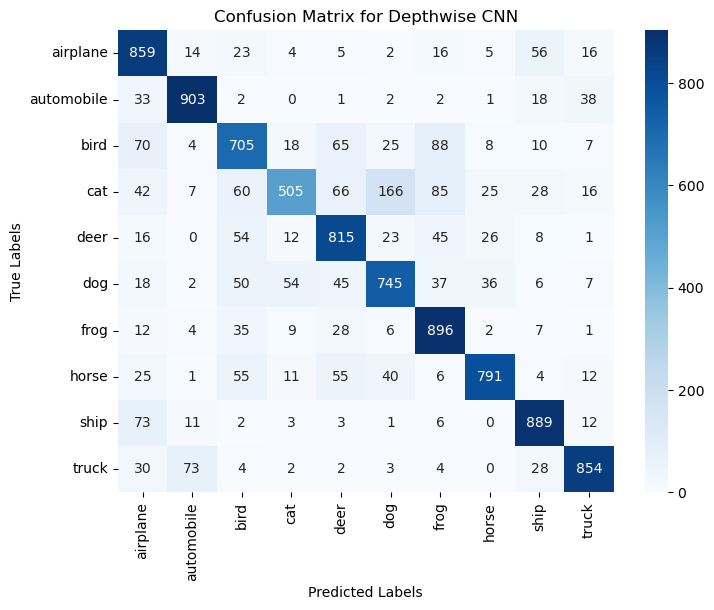

In [ ]:
preds_ds, labels_ds = evaluate_and_plot(model_ds, testloader, "Depthwise CNN")


Classification Report for Traditional CNN:

              precision    recall  f1-score   support

    airplane       0.82      0.87      0.84      1000
  automobile       0.92      0.92      0.92      1000
        bird       0.83      0.76      0.79      1000
         cat       0.65      0.77      0.70      1000
        deer       0.87      0.77      0.82      1000
         dog       0.83      0.71      0.77      1000
        frog       0.85      0.90      0.87      1000
       horse       0.81      0.90      0.85      1000
        ship       0.94      0.87      0.90      1000
       truck       0.90      0.90      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



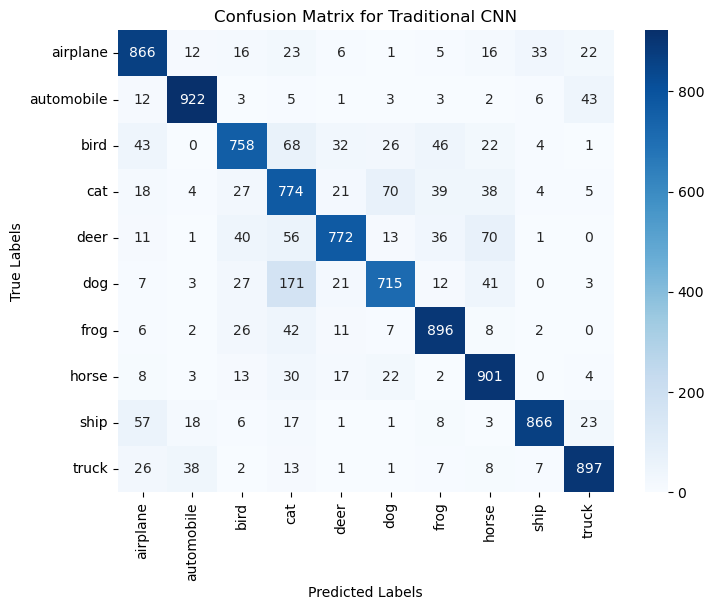

In [ ]:
preds_trad, labels_trad = evaluate_and_plot(model_trad, testloader, "Traditional CNN")

In [ ]:
def show_predictions(model, testloader, model_name):
    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = (img * 0.5) + 0.5
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {dataset.classes[preds[i].item()]}\nTrue: {dataset.classes[labels[i].item()]}")
        axes[i].axis("off")

    plt.suptitle(f"Sample Predictions - {model_name}")
    plt.show()

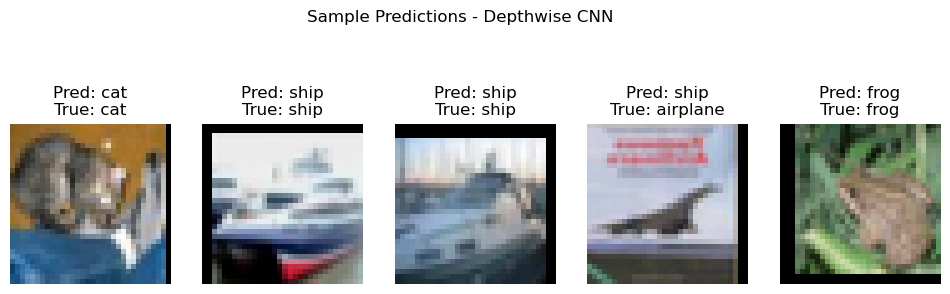

In [ ]:
show_predictions(model_ds, testloader, "Depthwise CNN")

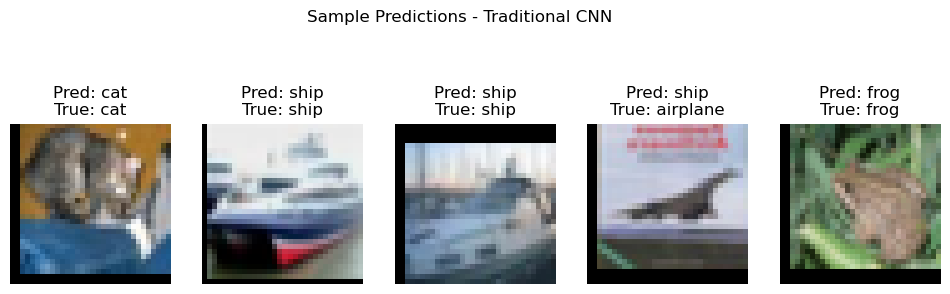

In [ ]:
show_predictions(model_trad, testloader, "Traditional CNN")